<a href="https://colab.research.google.com/github/oklawyer71/cyber_security/blob/main/Heart_Disease_Semi-Supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook Setup**

In [8]:
import os
print(os.getcwd())

/content


In [2]:
# Importing packages
import numpy as np               # linear algebra
import pandas as pd              # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import xgboost as xgb

import random
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV



In [1]:
# Install & Import Pycaret
!pip install pycaret[full]


In [3]:
# import ClassificationExperiment and init the class

from pycaret.classification import setup, compare_models, tune_model, evaluate_model
from pycaret.classification import setup, compare_models, tune_model
import pycaret.classification as pc
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline


In [4]:
# Mounting Google Drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_path = 'drive/My Drive/Colab Notebooks/heart.csv'

data = pd.read_csv(df_path, encoding='unicode_escape')

In [19]:
df_original = data.copy()
df = data.copy()

# **Data Exploration**

In [ ]:
# installing ydata-profiling package.  This tool will allow for better data visualization & exploration

!pip install  ydata-profiling matplotlib

In [ ]:
# Viewing the data through ydata-profiling

from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Dataset Profile")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Analyzing Data**

In [ ]:
print(f'Shape     : {df.shape}\n'
      f'Size      : {df.size}\n'
      f'Dimension : {df.ndim}')

Shape     : (303, 14)
Size      : 4242
Dimension : 2


In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


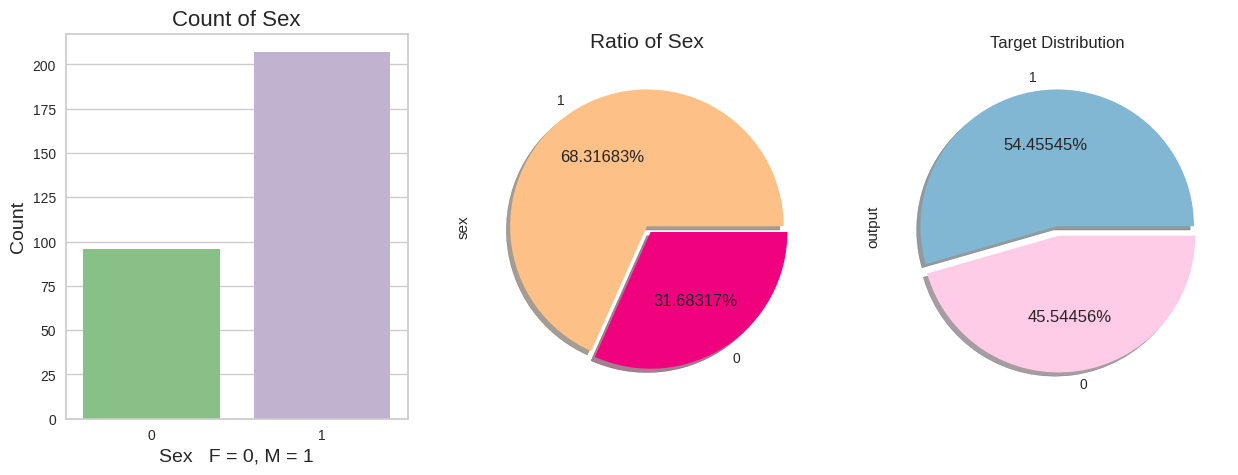

In [ ]:
chart_color = sns.color_palette('Accent')

fig, axs = plt.subplots(1,3,figsize = (15, 5))

ax = sns.countplot(data=df,
                   x = df['sex'],
                   ax = axs[0],
                   palette='Accent');

ax.set_xlabel('Sex   F = 0, M = 1', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
axs[0].set_title("Count of Sex", fontsize=16)

plt.xticks(rotation=45)
plt.xticks([0, 1], ["Female", "Male"])


ax2 = df['sex'].value_counts().plot.pie(explode=[0,0.05],
                                             colors=[chart_color[2], chart_color[5]],
                                             ax = axs[1],
                                             shadow = True,
                                             autopct='%.5f%%');
axs[1].set_title("Ratio of Sex", fontsize=15);

ax3 = df['output'].value_counts().plot.pie(explode=[0,0.07],
                                               colors=["#81b7d2", "#ffcce7"],
                                               autopct='%.5f%%',
                                               shadow = True,
                                               figsize=(15, 5))
ax3.set_title('Target Distribution');

[Text(0, 0, 'age'),
 Text(1, 0, 'sex'),
 Text(2, 0, 'cp'),
 Text(3, 0, 'trtbps'),
 Text(4, 0, 'chol'),
 Text(5, 0, 'fbs'),
 Text(6, 0, 'restecg'),
 Text(7, 0, 'thalachh'),
 Text(8, 0, 'exng'),
 Text(9, 0, 'oldpeak'),
 Text(10, 0, 'slp'),
 Text(11, 0, 'caa'),
 Text(12, 0, 'thall'),
 Text(13, 0, 'output')]

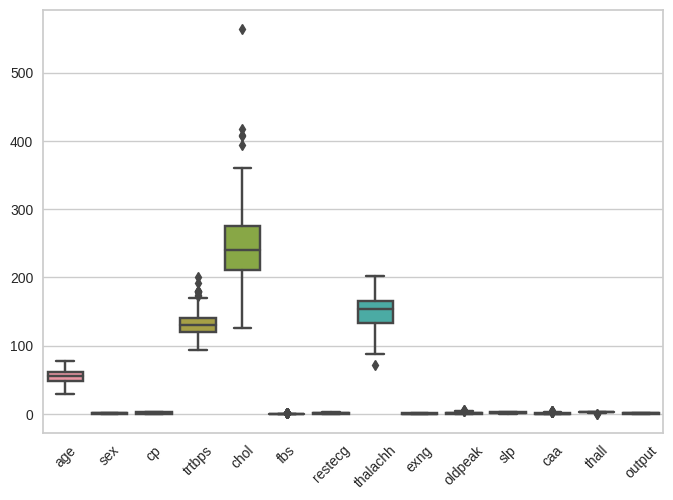

In [ ]:
bx = sns.boxplot(df)
bx.set_xticklabels(bx.get_xticklabels(),rotation=45)

# **Supervise Learning Part:**

## **Using Pycaret**

In [9]:
os.getcwd()
os.chdir('/content/drive/MyDrive/Colab Notebooks')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks'

In [10]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  gpu_available=False
  print('Not connected to a GPU')
else:
  gpu_available=True
  print(gpu_info)


Sun Nov  5 14:16:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
# In this code box, encoding categorical features for efficiency, scaling the continuous features

# Features/Columns, defined by categorical (cat) / continuous (con)
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall', 'output']
con_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

# encoding the categorical columns
ha_encoded_data = pd.get_dummies(df, columns = cat_cols, drop_first = True)

# defining the features and target
X = ha_encoded_data
Y = ha_encoded_data

# instantiating the scaler
scaler = StandardScaler()

# scaling the continuous features
X[con_cols] = scaler.fit_transform(X[con_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3,output_1
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1


In [41]:
# Creating a split of data for training, testing

train=X.sample(frac=0.8,random_state=200)
test=X.drop(train.index)

print(train.shape)
print(test.shape)

(242, 23)
(61, 23)


In [11]:
# Check to see if GPU is available for us to use through Colab

gpu_available

True

In [22]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [23]:
# check the type of exp
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [43]:
# init setup on exp
exp.setup(train, target = 'output_1', session_id = 123, use_gpu=gpu_available)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Description,Value
0,Session id,123
1,Target,output_1
2,Target type,Binary
3,Original data shape,"(242, 23)"
4,Transformed data shape,"(242, 23)"
5,Transformed train set shape,"(169, 23)"
6,Transformed test set shape,"(73, 23)"
7,Numeric features,22
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

In [44]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8201,0.9212,0.8576,0.8186,0.8303,0.6358,0.6510,0.0230
ridge,Ridge Classifier,0.8201,0.0000,0.8841,0.8069,0.8359,0.6346,0.6558,0.0220
rf,Random Forest Classifier,0.8201,0.8924,0.8583,0.8236,0.8335,0.6349,0.6474,0.3010
lda,Linear Discriminant Analysis,0.8201,0.9162,0.8841,0.8069,0.8359,0.6346,0.6558,0.0240
lr,Logistic Regression,0.8154,0.9180,0.8750,0.8061,0.8310,0.6245,0.6463,0.0990
et,Extra Trees Classifier,0.8108,0.9003,0.8508,0.8150,0.8240,0.6180,0.6342,0.2510
qda,Quadratic Discriminant Analysis,0.8013,0.9013,0.8152,0.8273,0.8112,0.5986,0.6111,0.0240
catboost,CatBoost Classifier,0.8013,0.8698,0.8333,0.8147,0.8156,0.5965,0.6095,24.1880
gbc,Gradient Boosting Classifier,0.7972,0.8802,0.8152,0.8122,0.8084,0.5900,0.5992,0.1230
lightgbm,Light Gradient Boosting Machine,0.7872,0.8706,0.8152,0.8199,0.8024,0.5683,0.5907,0.0600


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [45]:
# Use Pycaret for Interactive Visualizations of Best Models
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## **First Way:**

In [ ]:
# In this code box, encoding categorical features for efficiency, scaling the continuous features

# Features/Columns, defined by categorical (cat) / continuous (con)
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
con_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

# encoding the categorical columns
ha_encoded_data = pd.get_dummies(df, columns = cat_cols, drop_first = True)

# defining the features and target
X = ha_encoded_data.drop(['output'],axis=1)
y = ha_encoded_data[['output']]

# instantiating the scaler
scaler = StandardScaler()

# scaling the continuous features
X[con_cols] = scaler.fit_transform(X[con_cols])
print("The first 5 rows of X are")
X.head()

The first 5 rows of X are


,age,trtbps,chol,thalachh,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,exng_1,slp_1,slp_2,caa_1,caa_2,caa_3,caa_4,thall_1,thall_2,thall_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,1,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0


In [ ]:
# Creating a split of data for training, testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Showing the splits, by X / Y
print("X Train : ", X_train.shape)
print("X Test  : ", X_test.shape)
print("y Train : ", y_train.shape)
print("y Test  : ", y_test.shape)


X Train :  (242, 22)
X Test  :  (61, 22)
y Train :  (242, 1)
y Test  :  (61, 1)


In [ ]:
# XGB Model:

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=0)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.87702
[1]	validation_0-aucpr:0.90718
[2]	validation_0-aucpr:0.92056
[3]	validation_0-aucpr:0.92724
[4]	validation_0-aucpr:0.93266
[5]	validation_0-aucpr:0.93778
[6]	validation_0-aucpr:0.93323
[7]	validation_0-aucpr:0.94061
[8]	validation_0-aucpr:0.94330
[9]	validation_0-aucpr:0.94833
[10]	validation_0-aucpr:0.95131
[11]	validation_0-aucpr:0.95060
[12]	validation_0-aucpr:0.95211
[13]	validation_0-aucpr:0.94687
[14]	validation_0-aucpr:0.94835
[15]	validation_0-aucpr:0.94585
[16]	validation_0-aucpr:0.94921
[17]	validation_0-aucpr:0.95214
[18]	validation_0-aucpr:0.94876
[19]	validation_0-aucpr:0.94676
[20]	validation_0-aucpr:0.94463
[21]	validation_0-aucpr:0.94650
[22]	validation_0-aucpr:0.94752
[23]	validation_0-aucpr:0.94752
[24]	validation_0-aucpr:0.94675
[25]	validation_0-aucpr:0.94675
[26]	validation_0-aucpr:0.94752
[27]	validation_0-aucpr:0.94643


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Text(0.5, 489.55555555555554, 'Predicted label')

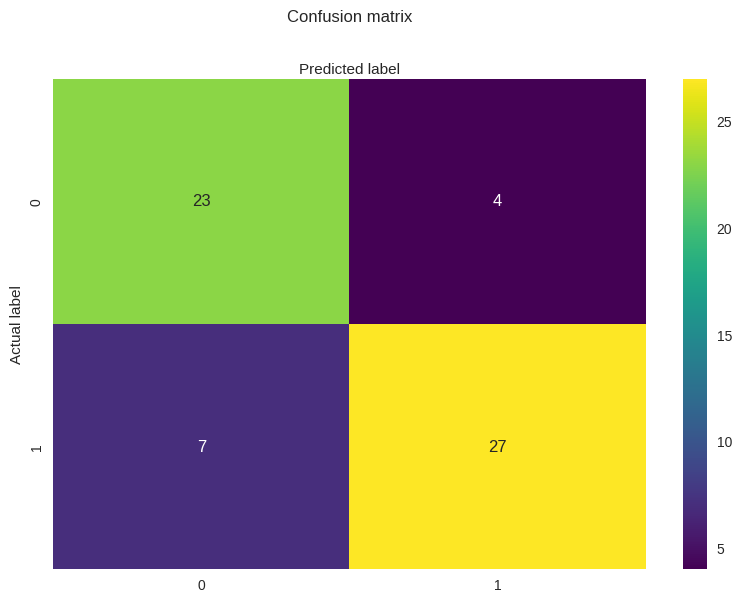

In [ ]:

y_pred = clf_xgb.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap = 'viridis' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


weight:  {'age': 48.0, 'trtbps': 46.0, 'chol': 63.0, 'thalachh': 38.0, 'oldpeak': 41.0, 'sex_1': 18.0, 'cp_2': 10.0, 'cp_3': 10.0, 'fbs_1': 2.0, 'restecg_1': 6.0, 'exng_1': 11.0, 'slp_1': 5.0, 'slp_2': 6.0, 'caa_1': 14.0, 'caa_2': 10.0, 'caa_3': 9.0, 'thall_1': 1.0, 'thall_2': 13.0, 'thall_3': 4.0}
gain:  {'age': 0.9522512555122375, 'trtbps': 0.8290062546730042, 'chol': 0.8318066596984863, 'thalachh': 1.2721613645553589, 'oldpeak': 1.3962582349777222, 'sex_1': 1.7105584144592285, 'cp_2': 1.5801066160202026, 'cp_3': 2.26969575881958, 'fbs_1': 1.2474819421768188, 'restecg_1': 0.48143234848976135, 'exng_1': 2.0124378204345703, 'slp_1': 0.5796618461608887, 'slp_2': 0.4808730185031891, 'caa_1': 1.4450130462646484, 'caa_2': 1.2995357513427734, 'caa_3': 2.03729510307312, 'thall_1': 0.7855958938598633, 'thall_2': 12.621553421020508, 'thall_3': 0.8508365750312805}
cover:  {'age': 8.018044471740723, 'trtbps': 7.7075700759887695, 'chol': 5.7403082847595215, 'thalachh': 8.802653312683105, 'oldpeak

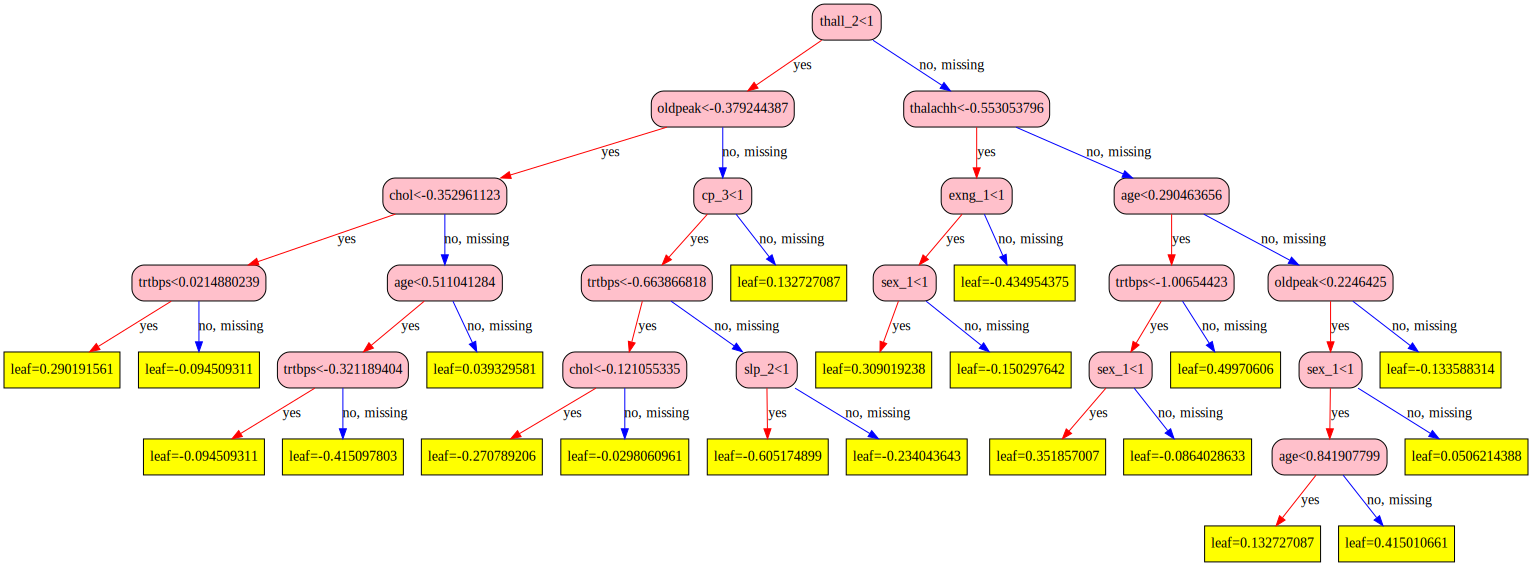

In [ ]:
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', 'style': 'filled, rounded', 'fillcolor': '#FFC0CB'}
leaf_params = {'shape': 'box', 'style': 'filled', 'fillcolor': '#FFFF00'}

xgb.to_graphviz(clf_xgb, num_trees=0, size='10,10', condition_node_params = node_params, leaf_node_params=leaf_params)

In [ ]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0, 0.25,1.0],
    'reg_lambda':[0,1.0,10.0]}

In [ ]:
GS_xgb = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=0), param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
GS_xgb.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0]},
             scoring='roc_auc')

In [ ]:
GS_xgb.best_params_

{'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0}

In [ ]:
grid_model_1 = xgb.XGBClassifier(max_depth=4, gamma=1.0, learning_rate=0.05, reg_lambda=10.0, random_state=0)
grid_model_1.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Text(0.5, 489.55555555555554, 'Predicted label')

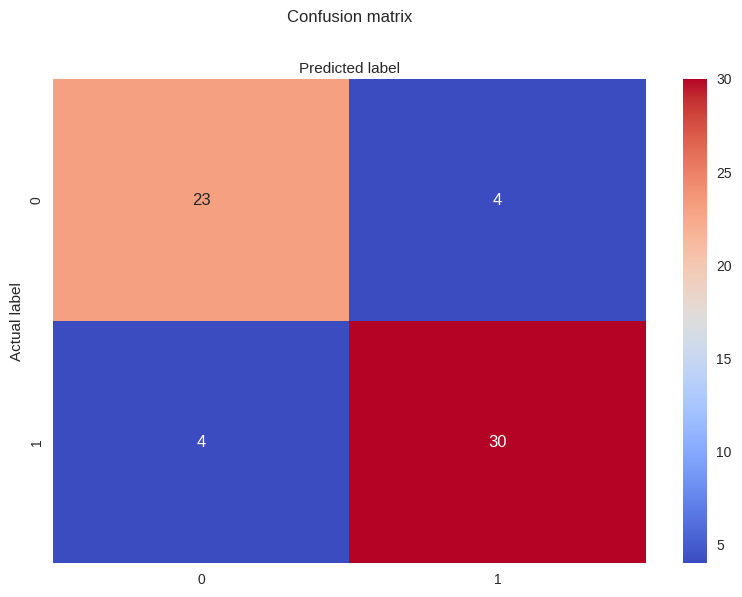

In [ ]:
y_pred = grid_model_1.predict(X_test)
cnf_matrix = confusion_matrix(y_test.values.ravel(), y_pred)

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='coolwarm' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

weight:  {'age': 31.0, 'trtbps': 36.0, 'chol': 38.0, 'thalachh': 54.0, 'oldpeak': 75.0, 'sex_1': 52.0, 'cp_1': 8.0, 'cp_2': 33.0, 'cp_3': 44.0, 'exng_1': 33.0, 'slp_1': 12.0, 'slp_2': 2.0, 'caa_1': 49.0, 'caa_2': 25.0, 'caa_3': 10.0, 'thall_2': 33.0, 'thall_3': 4.0}
gain:  {'age': 2.0214548110961914, 'trtbps': 1.9611958265304565, 'chol': 1.669573187828064, 'thalachh': 2.8472840785980225, 'oldpeak': 1.9775160551071167, 'sex_1': 1.9665418863296509, 'cp_1': 1.7264419794082642, 'cp_2': 2.4711034297943115, 'cp_3': 2.3756144046783447, 'exng_1': 4.904932498931885, 'slp_1': 2.6514720916748047, 'slp_2': 1.2915513515472412, 'caa_1': 1.7460540533065796, 'caa_2': 1.7127496004104614, 'caa_3': 2.1124579906463623, 'thall_2': 20.911746978759766, 'thall_3': 2.0668537616729736}
cover:  {'age': 17.932207107543945, 'trtbps': 18.959440231323242, 'chol': 20.009248733520508, 'thalachh': 22.876012802124023, 'oldpeak': 25.640010833740234, 'sex_1': 20.646684646606445, 'cp_1': 27.96772003173828, 'cp_2': 32.20279

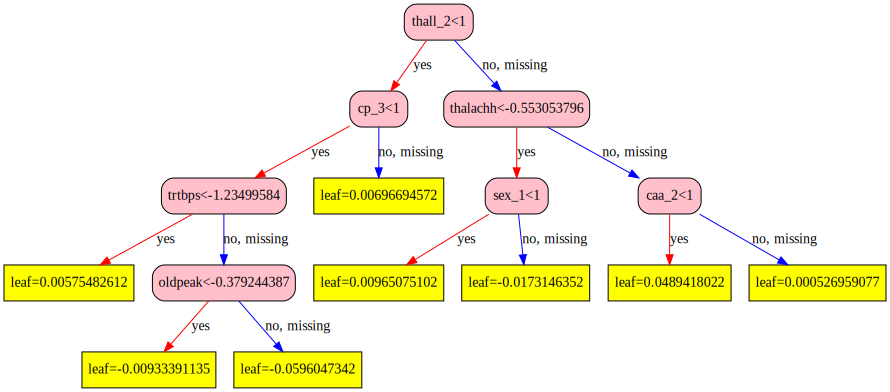

In [ ]:
bst = grid_model_1.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', 'style': 'filled, rounded', 'fillcolor': '#FFC0CB'}
leaf_params = {'shape': 'box', 'style': 'filled', 'fillcolor': '#FFFF00'}

xgb.to_graphviz(grid_model_1, num_trees=0, size='10,10', condition_node_params = node_params, leaf_node_params=leaf_params)

In [ ]:
param_grid_2 = {
    'max_depth':[1,2,3],
    'learning_rate':[0.1,0.15,0.2],
    'gamma':[0.25],
    'reg_lambda':[10.0, 20, 100]}

In [ ]:
GS_xgb_2 = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', seed=0), param_grid=param_grid_2, scoring='roc_auc', cv=3, n_jobs=-1)
GS_xgb_2.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.25], 'learning_rate': [0.1, 0.15, 0.2],
                         'max_depth': [1, 2, 3],
                         'reg_lambda': [10.0, 20, 100]},
             scoring='roc_auc')

In [ ]:
GS_xgb_2.best_params_

{'gamma': 0.25, 'learning_rate': 0.15, 'max_depth': 2, 'reg_lambda': 10.0}

In [ ]:
grid_model_2 = xgb.XGBClassifier(max_depth=2, gamma=0.25, learning_rate=0.15, reg_lambda=10.0, random_state=0)
grid_model_2.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Text(0.5, 489.55555555555554, 'Predicted label')

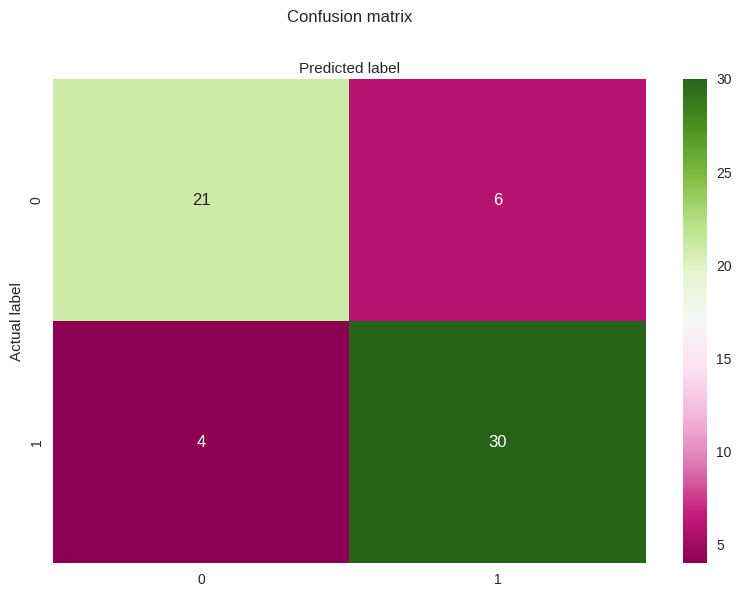

In [ ]:
y_pred = grid_model_2.predict(X_test)
cnf_matrix = confusion_matrix(y_test.values.ravel(), y_pred)

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='PiYG' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

weight:  {'age': 18.0, 'trtbps': 11.0, 'chol': 16.0, 'thalachh': 28.0, 'oldpeak': 32.0, 'sex_1': 20.0, 'cp_1': 1.0, 'cp_2': 15.0, 'cp_3': 14.0, 'restecg_1': 3.0, 'exng_1': 19.0, 'slp_1': 5.0, 'caa_1': 24.0, 'caa_2': 20.0, 'caa_3': 23.0, 'thall_2': 9.0, 'thall_3': 5.0}
gain:  {'age': 1.4033774137496948, 'trtbps': 0.6560932397842407, 'chol': 1.3434512615203857, 'thalachh': 2.03950572013855, 'oldpeak': 2.3987481594085693, 'sex_1': 1.6019130945205688, 'cp_1': 4.921388626098633, 'cp_2': 2.4747419357299805, 'cp_3': 2.1365628242492676, 'restecg_1': 0.8298919796943665, 'exng_1': 3.5673234462738037, 'slp_1': 2.6105926036834717, 'caa_1': 1.706369400024414, 'caa_2': 1.6430305242538452, 'caa_3': 1.185407042503357, 'thall_2': 24.07868003845215, 'thall_3': 0.7924124598503113}
cover:  {'age': 21.658723831176758, 'trtbps': 25.15400505065918, 'chol': 28.349578857421875, 'thalachh': 24.537813186645508, 'oldpeak': 29.402210235595703, 'sex_1': 35.57544708251953, 'cp_1': 36.8425178527832, 'cp_2': 38.360557

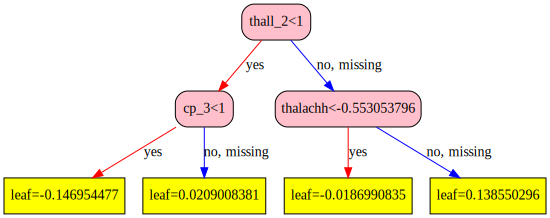

In [ ]:
bst = grid_model_2.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', 'style': 'filled, rounded', 'fillcolor': '#FFC0CB'}
leaf_params = {'shape': 'box', 'style': 'filled', 'fillcolor': '#FFFF00'}

xgb.to_graphviz(grid_model_2, num_trees=0, size='10,10', condition_node_params = node_params, leaf_node_params=leaf_params)

## **Second Way:**

In [ ]:
df_2 = data.copy()
df_2

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


[Text(0, 0, 'age'),
 Text(1, 0, 'sex'),
 Text(2, 0, 'cp'),
 Text(3, 0, 'trtbps'),
 Text(4, 0, 'chol'),
 Text(5, 0, 'fbs'),
 Text(6, 0, 'restecg'),
 Text(7, 0, 'thalachh'),
 Text(8, 0, 'exng'),
 Text(9, 0, 'oldpeak'),
 Text(10, 0, 'slp'),
 Text(11, 0, 'caa'),
 Text(12, 0, 'thall'),
 Text(13, 0, 'output')]

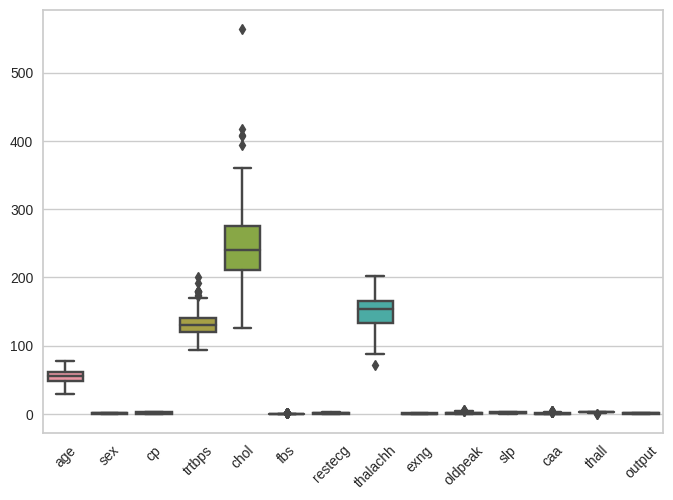

In [ ]:
bx = sns.boxplot(df)
bx.set_xticklabels(bx.get_xticklabels(),rotation=45)

### **Way 2-1**

In [ ]:
# Set up our experiment
from pycaret.classification import *
exp = ClassificationExperiment()
exp = setup(data=df_2, target='output', session_id=123)

,Description,Value
0,Session id,123
1,Target,output
2,Target type,Binary
3,Original data shape,"(303, 14)"
4,Transformed data shape,"(303, 14)"
5,Transformed train set shape,"(212, 14)"
6,Transformed test set shape,"(91, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model_1 = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8201,0.9212,0.8576,0.8186,0.8303,0.6358,0.6510,0.0270
ridge,Ridge Classifier,0.8201,0.0000,0.8841,0.8069,0.8359,0.6346,0.6558,0.0260
rf,Random Forest Classifier,0.8201,0.8924,0.8583,0.8236,0.8335,0.6349,0.6474,0.2060
lda,Linear Discriminant Analysis,0.8201,0.9162,0.8841,0.8069,0.8359,0.6346,0.6558,0.0530
lr,Logistic Regression,0.8154,0.9180,0.8750,0.8061,0.8310,0.6245,0.6463,0.9220
catboost,CatBoost Classifier,0.8113,0.9040,0.8508,0.8160,0.8274,0.6168,0.6284,1.2440
et,Extra Trees Classifier,0.8108,0.9003,0.8508,0.8150,0.8240,0.6180,0.6342,0.3040
qda,Quadratic Discriminant Analysis,0.8013,0.9013,0.8152,0.8273,0.8112,0.5986,0.6111,0.0270
gbc,Gradient Boosting Classifier,0.7972,0.8802,0.8152,0.8122,0.8084,0.5900,0.5992,0.1880
xgboost,Extreme Gradient Boosting,0.7970,0.8618,0.8417,0.8072,0.8137,0.5875,0.6070,0.1160


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
# Perform feature selection (you can choose a different method)
best_features = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8201,0.9212,0.8576,0.8186,0.8303,0.6358,0.6510,0.0280
ridge,Ridge Classifier,0.8201,0.0000,0.8841,0.8069,0.8359,0.6346,0.6558,0.0250
rf,Random Forest Classifier,0.8201,0.8924,0.8583,0.8236,0.8335,0.6349,0.6474,0.1980
lda,Linear Discriminant Analysis,0.8201,0.9162,0.8841,0.8069,0.8359,0.6346,0.6558,0.0510
lr,Logistic Regression,0.8154,0.9180,0.8750,0.8061,0.8310,0.6245,0.6463,0.1240
catboost,CatBoost Classifier,0.8113,0.9040,0.8508,0.8160,0.8274,0.6168,0.6284,1.3690
et,Extra Trees Classifier,0.8108,0.9003,0.8508,0.8150,0.8240,0.6180,0.6342,0.3070
qda,Quadratic Discriminant Analysis,0.8013,0.9013,0.8152,0.8273,0.8112,0.5986,0.6111,0.0260
gbc,Gradient Boosting Classifier,0.7972,0.8802,0.8152,0.8122,0.8084,0.5900,0.5992,0.1720
xgboost,Extreme Gradient Boosting,0.7970,0.8618,0.8417,0.8072,0.8137,0.5875,0.6070,0.1000


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

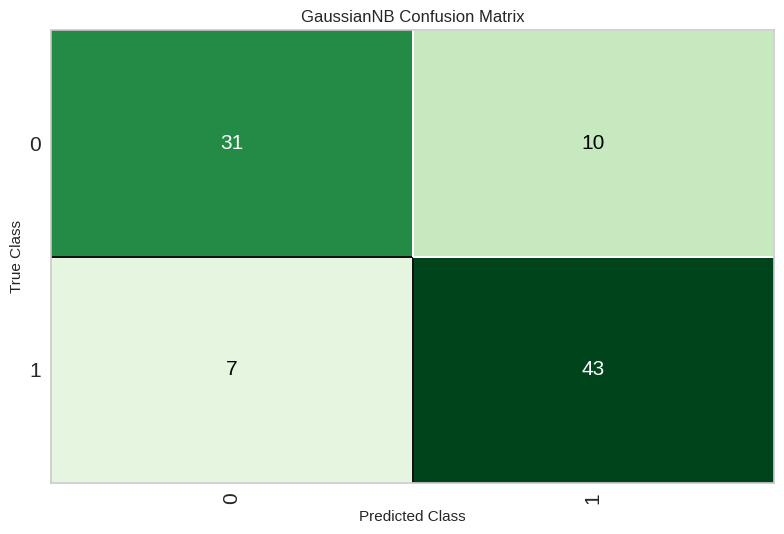

In [ ]:

from pycaret.classification import plot_model
plot_model(best_features, plot = 'confusion_matrix')

In [ ]:
from pycaret.classification import evaluate_model
evaluate_model(best_features)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
from pycaret.classification import predict_model
holdout_pred = predict_model(best_features)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8132,0.8741,0.8600,0.8113,0.8350,0.6202,0.6216


In [ ]:
holdout_pred.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,prediction_label,prediction_score
204,62,0,0,160,164,0,0,145,0,6.2,0,3,3,0,0,1.0000
293,67,1,2,152,212,0,0,150,0,0.8,1,0,3,0,1,0.6576
84,42,0,0,102,265,0,0,122,0,0.6,1,0,2,1,1,0.9235
141,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1,1,0.9485
290,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,1,0.7094
248,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0,0,0.6245
217,63,1,0,130,330,1,0,132,1,1.8,2,3,3,0,0,0.9999
286,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0,1,0.9886
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,0,1.0000
172,58,1,1,120,284,0,0,160,0,1.8,1,0,2,0,1,0.6194


In [ ]:
tuned_model = tune_model(best_features)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9091,0.9917,1.0000,0.8571,0.9231,0.8136,0.8281
1,0.8636,0.9583,1.0000,0.8000,0.8889,0.7179,0.7483
2,0.8571,0.9815,0.8333,0.9091,0.8696,0.7123,0.7156
3,0.8095,0.9444,1.0000,0.7500,0.8571,0.5882,0.6455
4,0.8571,0.9815,0.8333,0.9091,0.8696,0.7123,0.7156
5,0.8571,0.9455,0.8182,0.9000,0.8571,0.7149,0.7182
6,0.9048,0.9000,1.0000,0.8462,0.9167,0.8073,0.8228
7,0.6667,0.8273,0.7273,0.6667,0.6957,0.3288,0.3303
8,0.8571,0.9364,0.9091,0.8333,0.8696,0.7123,0.7156


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


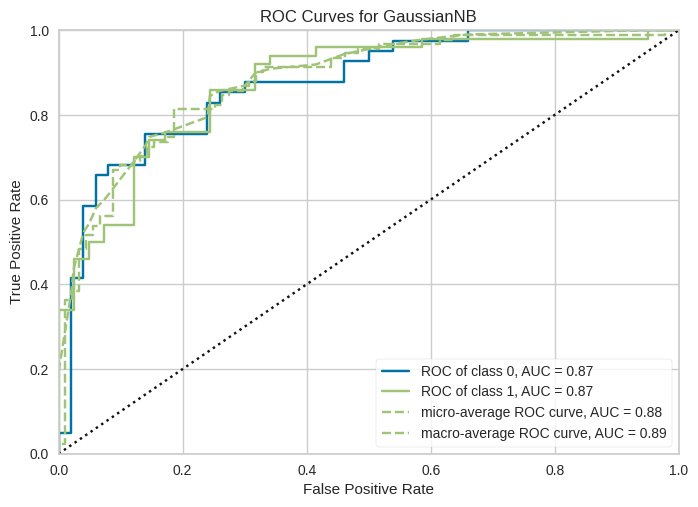

In [ ]:
plot_model(tuned_model)

In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
holdout_pred = predict_model(tuned_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8132,0.8741,0.8600,0.8113,0.8350,0.6202,0.6216


In [ ]:
from pycaret.classification import finalize_model
final_model = finalize_model(tuned_model)

print(final_model)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'sex', 'cp', 'trtbps',
                                             'chol', 'fbs', 'restecg',
                                             'thalachh', 'exng', 'oldpeak',
                                             'slp', 'caa', 'thall'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
          

### **Way 2-2**

In [ ]:
# columns_to_drop = ["sex", "age"]
# df_2.drop(columns=columns_to_drop, inplace=True)
# df_2

In [ ]:

# target_column_name = "cp"

# # Handle missing values
# df_2.dropna(inplace=True)           # Remove rows with missing values, you can customize this based on your needs

# # if task_type == 'classification':

# import ClassificationExperiment and init the class
# from pycaret.classification import ClassificationExperiment
# exp = ClassificationExperiment()
# clf = exp.setup(df_2, target = target_column_name, session_id=123, normalize=True, transformation=True)
# OR
# import pycaret.classification as pc
# clf = pc.setup(data, target=target_column_name, session_id=123, normalize=True, transformation=True)
# best_model_1 = pc.compare_models()

# # if task_type == 'regression':
# import pycaret.regression as pr
# reg = pr.setup(data, target=target_column_name, session_id=123, normalize=True, transformation=True)
# best_model_2 = pr.compare_models()

In [ ]:
# from pycaret.classification import setup, compare_models, tune_model
# import pycaret.classification as pc
# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.pipeline import Pipeline

# # Perform feature selection (you can choose a different method)
# best_features = compare_models(fold=5, sort='F1')

In [ ]:
# # Create a custom pipeline with feature selection and Logistic Regression
# pipeline = Pipeline([
#     ('select', SelectKBest(score_func=f_classif)),
#     ('lr', LogisticRegression())
# ])


In [ ]:
# # Define a custom grid for hyperparameter tuning
# param_grid = {
#     'select__k': [1, 2, 3, 4, 5],  # Adjust the number of selected features
#     'lr__C': [0.001, 0.01, 0.1, 1, 10],  # Adjust regularization strength
# }


In [ ]:
# # Tune the custom pipeline with the custom grid
# tuned_lr = tune_model(pipeline, custom_grid=param_grid)

In [ ]:
# # Create and train multiple classification models
# model1 = pc.create_model('lr')
# pc.plot_model(model1)

# model2 = pc.create_model('rf')
# pc.plot_model(model2)

# model3 = pc.create_model('xgboost')
# pc.plot_model(model3)

# # Blend the classification models
# blended_model = pc.blend_models(estimator_list=[model1, model2, model3])
# pc.plot_model(blended_model)

# # Stack the classification models
# stacked_model = pc.stack_models(estimator_list=[model1, model2], meta_model=model3)
# pc.plot_model(stacked_model)

In [ ]:
# from pycaret.classification import tune_model, plot_model

# # Tune the model using the 'random' tuner without specifying a search library
# tuned_model = tune_model(blended_model, n_iter=10)
# plot_model(tuned_model)

In [ ]:
# from pycaret.classification import evaluate_model

# evaluate_model(tuned_model)

In [ ]:
# holdout_pred = predict_model(tuned_model);

In [ ]:
# from pycaret.classification import finalize_model
# final_model = finalize_model(tuned_model)

# print(final_model)

# **Semi-Supervise Learning Part:**

---


In [ ]:
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
print(f'Shape     : {df.shape}\n'
      f'Size      : {df.size}\n'
      f'Dimension : {df.ndim}')

Shape     : (303, 14)
Size      : 4242
Dimension : 2


## **First Way:** This code combines labeled and pseudo-labeled data using Label Propagation and then trains a Random Forest classifier on the combined dataset.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Separate labeled and unlabeled data
labeled_data = data[data['output'].notnull()]
unlabeled_data = data[data['output'].isnull()]

# Split labeled data into features and target
X_labeled = labeled_data.drop(columns=['output'])
y_labeled = labeled_data['output']

# Split labeled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)

# Train a LabelPropagation model
label_propagation = LabelPropagation()
label_propagation.fit(X_labeled, y_labeled)



LabelPropagation(gamma=20, kernel='rbf', max_iter=1000, n_jobs=None,
                 n_neighbors=7, tol=0.001)

In [ ]:
print("X Train : ", X_train.shape)
print("X Test  : ", X_test.shape)
print("y Train : ", y_train.shape)
print("y Test  : ", y_test.shape)


X Train :  (242, 13)
X Test  :  (61, 13)
y Train :  (242,)
y Test  :  (61,)


In [ ]:
# Propagate labels to the unlabeled data
unlabeled_data = data.drop(columns=['output'])
pseudo_labels = label_propagation.predict(unlabeled_data)

# Combine labeled and pseudo-labeled data
X_combined = pd.concat([X_labeled, unlabeled_data])
y_combined = pd.concat([y_labeled, pd.Series(pseudo_labels, name='output')])

# Train a classification model (e.g., Random Forest)
classifier = RandomForestClassifier()
classifier.fit(X_combined, y_combined)

# Evaluate the model
y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        32

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



## **Second Way:**  This code combines labeled and pseudo-labeled data using Label Propagation and then trains a Active Learner and estimator is Random Forest classifier on the combined dataset.

In [ ]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-0xw87dil
  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-0xw87dil
  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 1.1 MB/s eta 0:00:00
  Created wheel for modAL-python: filename=modAL_python-0.4.2-py3-none-any.whl size=32650 sha256=2c5ddf99b1104f3d747e9df707ffa27f9a0358db540cc183e2b284df37a2e19e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_vs08nnx/wheels/d9/fb/59/7deb61b460c1c36394cd093758986ff7d36f71352dcb2e02c5
Successfully built modAL-python


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [ ]:
# Separate labeled and unlabeled data
labeled_data = data[data['output'].notnull()]
unlabeled_data = data[data['output'].isnull()]

# Split labeled data into features and target
X_labeled = labeled_data.drop(columns=['output'])
y_labeled = labeled_data['output']

# Split labeled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)



In [ ]:
# Train a LabelPropagation model
label_propagation = LabelPropagation()
label_propagation.fit(X_labeled, y_labeled)

# Propagate labels to the unlabeled data
# pseudo_labels = label_propagation.predict(unlabeled_data.drop(columns=['output']))
unlabeled_data = data.drop(columns=['output'])
pseudo_labels = label_propagation.predict(unlabeled_data)

# Convert pseudo_labels to a Pandas Series
pseudo_labels_series = pd.Series(pseudo_labels, name='output')

# Combine labeled and pseudo-labeled data
# X_combined = pd.concat([X_labeled, unlabeled_data.drop(columns=['output'])])
X_combined = pd.concat([X_labeled, unlabeled_data])
y_combined = pd.concat([y_labeled, pseudo_labels_series])  # Use the Pandas Series here


In [ ]:
# Initialize the active learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_labeled,
    y_training=y_labeled
)

In [ ]:
# Query new instances for labeling
query_idx, query_instance = learner.query(unlabeled_data)

# Manually label the queried instances and update the learner
# learner.teach(X_unlabeled[query_idx], y_new_labels)

# Train a classification model (e.g., Random Forest)
classifier = RandomForestClassifier()
classifier.fit(X_combined, y_combined)

# Evaluate the model
y_pred = classifier.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

# Define hyperparameters and grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

# Perform grid search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_combined, y_combined)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        32

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 100}
